# COURSE: A deep understanding of deep learning
## SECTION: FFNs
### LECTURE: FFN to classify digits
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/dudl/?couponCode=202201

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

C:\Users\U7W20E6\AppData\Local\Temp/ipykernel_4688/2889067548.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Import and process the data

In [2]:
# import dataset (comes with colab!)
data = np.loadtxt(open('../sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

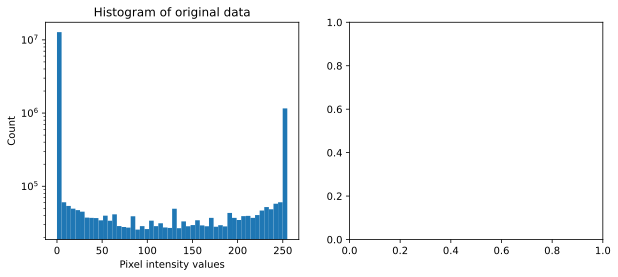

In [3]:
from sklearn.preprocessing import minmax_scale
# normalize the data to a range of [0 1]
# dataNorm = data / np.max(data)
# dataNorm = minmax_scale(data)

fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(data.flatten(),50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of original data')
ax[0].set_yscale('log')

# ax[1].hist(dataNorm.flatten(),50)
# ax[1].set_xlabel('Pixel intensity values')
# ax[1].set_ylabel('Count')
# ax[1].set_title('Histogram of normalized data')
# ax[1].set_yscale('log')

plt.show()

In [4]:
# dataNorm.max(), dataNorm.min()

# Create train/test groups using DataLoader

In [5]:
# Step 1: convert to tensor
# dataT   = torch.tensor( dataNorm ).float()
dataT   = torch.tensor( data ).float()
labelsT = torch.tensor( labels ).long() # long = int64

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)

train_data = minmax_scale(train_data.detach().numpy())
train_data = torch.tensor(train_data).float()
# test_data = minmax_scale(test_data.detach().numpy())
# test_data = torch.tensor(test_data).float()

print(f'Train data: ({train_data.min()}, {train_data.max()})')
print(f'Test data: ({test_data.min()}, {test_data.max()})')


# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

Train data: (0.0, 1.0)
Test data: (0.0, 255.0)


# Create the DL model

In [6]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return torch.log_softmax( self.output(x),axis=1 )
      # NEW HERE: log-softmax the output, because I'm using NLLLoss instead of CrossEntropyLoss
  
  # create the model instance
  net = mnistNet()
  
  # loss function
  lossfun = nn.NLLLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [7]:
# test the model with one batch
net,lossfun,optimizer = createTheMNISTNet()

X,y = iter(train_loader).next()
yHat = net(X)

# values are log-probability of each number (0-9)
# print(torch.exp(yHat))

# now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

 
Loss:
tensor(2.3489, grad_fn=<NllLossBackward0>)


In [8]:
y

tensor([8, 4, 3, 4, 7, 0, 8, 2, 1, 1, 9, 2, 2, 2, 9, 1, 7, 9, 2, 6, 0, 6, 4, 0,
        0, 6, 6, 0, 1, 2, 1, 0])

# Create a function that trains the model

In [9]:
# a function that trains the model

def funtion2trainTheModel():

  # number of epochs
  numepochs = 60
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros((numepochs, 2))
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train()
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi, 0] = np.mean(batchLoss)

    net.eval()
    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad():
      yHat = net(X)
      
    loss = lossfun(yHat,y)
    losses[epochi, 1] = loss
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


# Run the model and show the results!

In [10]:
trainAcc,testAcc,losses,net = funtion2trainTheModel()


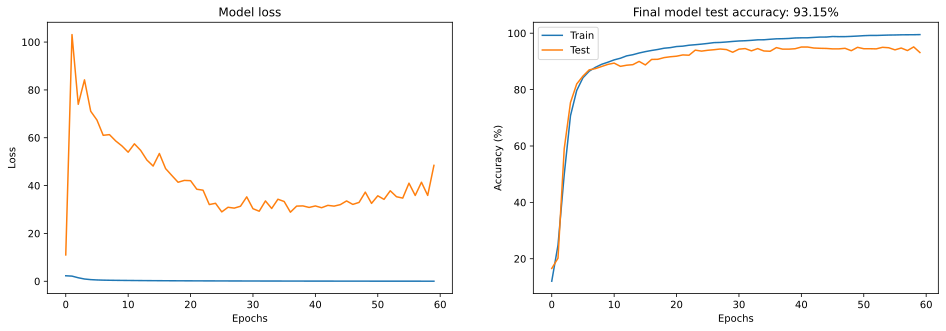

In [19]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
# ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
# ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

# Inspect the results in more detail

In [12]:
# run the model through for the test data
X,y = next(iter(test_loader))
predictions = net(X).detach()

predictions

tensor([[ -2468.5269,  -4819.1196,  -2077.7007,  ...,  -1688.2415,
          -2202.1433,      0.0000],
        [ -4405.5635,  -6728.9150,  -2232.4011,  ...,      0.0000,
          -5856.4258,  -4202.9663],
        [ -2393.5615,  -5620.2314,  -2861.5278,  ...,  -5386.0815,
          -3678.6340,  -6217.4692],
        ...,
        [ -1857.8330,  -5359.2686,  -2516.0024,  ...,  -3060.0352,
          -1455.1741,      0.0000],
        [ -4139.8428,  -4293.8613,  -2861.0105,  ...,      0.0000,
          -2814.9722,  -1447.4231],
        [ -4732.3335,  -6170.6064,  -3431.4302,  ...,  -9141.9521,
          -7733.2798, -11038.6611]])

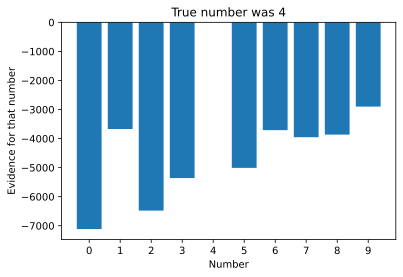

In [13]:
# Evidence for all numbers from one sample
sample2show = 12

plt.bar(range(10),predictions[sample2show]) # try adding exp!
# plt.bar(range(10), np.exp(predictions[sample2show])) # try adding exp!
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Evidence for that number')
plt.title('True number was %s' %y[sample2show].item())
plt.show()

[  13   67   71   89  105  114  116  119  134  160  175  184  197  207
  212  214  217  224  260  267  273  296  299  305  310  339  341  364
  365  372  393  398  421  432  456  475  479  505  540  552  586  602
  603  624  631  636  643  662  667  677  711  712  724  725  756  763
  768  795  808  815  820  824  835  837  864  872  907  911  980  983
  986  990  992 1010 1013 1014 1017 1023 1063 1082 1089 1105 1118 1149
 1152 1157 1216 1229 1231 1232 1238 1239 1245 1249 1280 1281 1284 1294
 1297 1302 1327 1329 1337 1390 1430 1487 1489 1511 1513 1515 1517 1519
 1530 1535 1546 1597 1616 1635 1657 1659 1693 1711 1741 1745 1752 1782
 1787 1796 1843 1846 1864 1881 1890 1925 1932 1934 1948]


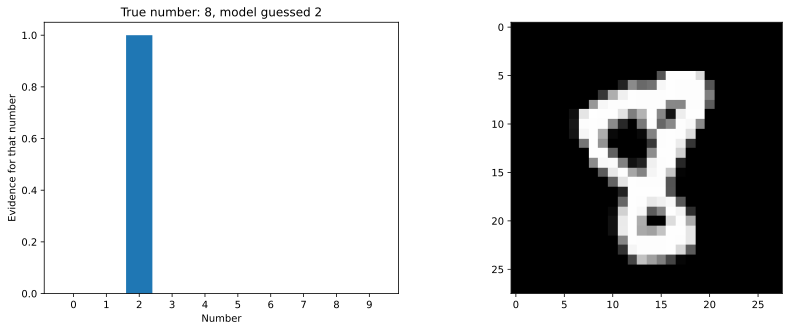

In [14]:
# find the errors
errors = np.where( torch.max(predictions,axis=1)[1] != y )[0]
print(errors)

# Evidence for all numbers from one sample
sample2show = 10

fig,ax = plt.subplots(1,2,figsize=(14,5))

ax[0].bar(range(10),np.exp(predictions[errors[sample2show]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
ax[0].set_title('True number: %s, model guessed %s' 
                %( y[errors[sample2show]].item(), torch.argmax(predictions[errors[sample2show]]).item() ))

ax[1].imshow( np.reshape(X[errors[sample2show],:],(28,28)) ,cmap='gray')

plt.show()

# Additional explorations

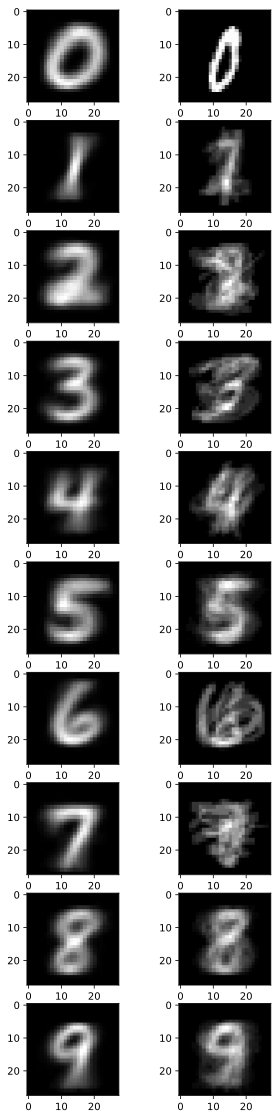

In [15]:
fig, ax = plt.subplots(10, 2, figsize=(5, 20))
ax = ax.flatten()
for i, num in zip(range(0, 20, 2), range(10)):
    corrects = test_data.tensors[0][np.where((torch.max(predictions, axis=1)[1] == y) & (y == num))[0]]
    errors = test_data.tensors[0][np.where((torch.max(predictions, axis=1)[1] != y) & (y == num))[0]]
    corrects_avg = corrects.mean(axis=0)
    errors_avg = errors.mean(axis=0)
    # print(c_labels[1])
    ax[i].imshow( np.reshape(corrects_avg, (28,28)) ,cmap='gray')
    ax[i+1].imshow( np.reshape(errors_avg, (28,28)) ,cmap='gray')

In [16]:
# torch.max(predictions, axis=1)[1]
indicies = np.where((np.exp(predictions) > 0.1).sum(axis=1) > 1)[0]

In [17]:
sample2show = indicies[3]

fig,ax = plt.subplots(1,2,figsize=(14,5))

ax[0].bar(range(10),np.exp(predictions[sample2show]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
ax[0].set_title('True number: %s, model guessed %s' 
                %( y[sample2show].item(), torch.argmax(predictions[sample2show]).item() ))

ax[1].imshow( np.reshape(test_data.tensors[0][sample2show],(28,28)) ,cmap='gray')

plt.show()

IndexError: index 3 is out of bounds for axis 0 with size 1

In [ ]:
# 1) Average together the correct 7's and the error 7's, and make images of them (that is, one image
#    of all correct 7's and one image of all incorrectly labeled 7's). How do they look?
# 
# 2) Repeat #1 for all numbers to produce a 2x10 matrix of images with corrects on top
#    and errors on the bottom.
# 
# 3) Identify "almost errors," which we can define as correct categorizations that had a probability of
#    e.g., >.1 for any other number. Make images of some of these numbers. Can you understand why the model
#    was confused?
# 
# 4) I didn't use .train(), .eval(), or no_grad() here. Is that a problem? Can you add those in without checking
#    other notebooks?
# 